Replayed from Brian Keng's blog

[Importance sampling and estimating marginal likelhood in variational autoencoders](https://bjlkeng.github.io/posts/importance-sampling-and-estimating-marginal-likelihood-in-variational-autoencoders/)

In [44]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 GeneralizedAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SaliencybasedGeneralizedAnomalyScoreV2, 
                 FFTbasedGeneralizedAnomalyScoreV2, KMeansAnomalyScoreV2, MatrixProfileAnomalyScore)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import networkx as nx
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [8]:
# DAG
dag = [
     {'depends': [], 'duration': 4},
     {'depends': [0], 'duration': 4},
     {'depends': [0], 'duration': 2},
     {'depends': [1], 'duration': 5},
     {'depends': [1], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [2], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [4, 5, 6], 'duration': 2},
     {'depends': [3, 7, 8], 'duration': 2},
]

for i, task in enumerate(dag):
    print("Task {}: duration: {}, depends on {}".format(i+1, task['duration'], [x+1 for x in task['depends']]))

Task 1: duration: 4, depends on []
Task 2: duration: 4, depends on [1]
Task 3: duration: 2, depends on [1]
Task 4: duration: 5, depends on [2]
Task 5: duration: 2, depends on [2]
Task 6: duration: 3, depends on [3]
Task 7: duration: 2, depends on [3]
Task 8: duration: 3, depends on [3]
Task 9: duration: 2, depends on [5, 6, 7]
Task 10: duration: 2, depends on [4, 8, 9]


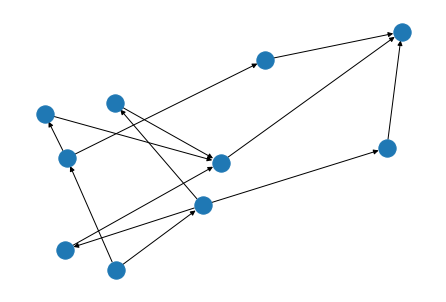

In [41]:
DG = nx.DiGraph()

for i,d in zip(range(len(dag)),dag):
    DG.add_node(i, duration = d['duration'])
    for j in d['depends']:
        DG.add_edge(j,i)
#pos = nx.shell_layout(DG)
pos = None
nx.draw(DG, pos=pos)

In [46]:
def simulate(n, dag):
    samples = []
    for task in dag:
        samples.append(np.random.exponential(task['duration'], n))
   
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i, :] = np.max(times[task['depends'], :] + samples[i], axis=0)
        else:
            times[i, :] = samples[i]
            
    df = pd.DataFrame(times).transpose()
    df.columns = ['task_' + str(x+1) for x in df.columns]
    return df
        
simulate(3, dag)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,5.482643,11.629945,12.731405,21.674304,12.197417,14.946378,13.042843,16.747571,15.472576,23.125470
1,2.319358,5.523167,3.999478,7.335707,6.594443,5.486903,5.401357,4.534476,7.645027,14.457258
2,5.276283,11.171767,5.959313,26.963838,11.696910,6.370151,6.286959,8.225410,13.365134,28.773864


,N,count,ratio
0,1000,0,0.000000
1,10000,0,0.000000
2,50000,1,0.000020
3,100000,4,0.000040
4,500000,17,0.000034
5,1000000,25,0.000025
6,5000000,157,0.000031


<AxesSubplot:xlabel='N', ylabel='ratio'>

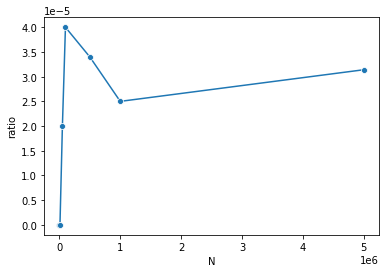

In [49]:
# Number of times we go over 70 day time limit at different time limits
trials = []
for N in [1000, 10000, 50000, 100000, 500000, 1000000, 5000000]:
    df = simulate(N, dag)
    count = len(df[df.task_10 > 70])
    trials.append({'N': N, 'count': count, 'ratio': count / len(df)})
                  
trials = pd.DataFrame(trials)
display(trials)
sns.lineplot(x='N', y='ratio', data=trials, markers=True, marker='o')

#### Put more weights on longer runs

and exploit importance weight sampling

$$
\int_{\mathcal{D}} f(x)dp = \int_{\mathcal{D}} \frac{f(x)p(x)}{q(x)} dq \approx
    \frac{1}{n} \sum_{i}^{n} \frac{ f(x_i)p(x_i) }{q(x_i)},  \: where \: x_i \sim  q
$$


We can use this to 'stretch' the duration of tasks (especially critical tasks) by a task specific lambda value. Since the duration of a task is independent, "correcting" the effects of importance weighting amounts to multiplying the integrals over p/q per task.

Hence with the original task duration denoted by theta and the "stretch" factor denoted by lambda

$$
        \frac{1}{n} \sum_{i}^{n} D_{i}(T > 70) \prod_{j}^{len(dag)} \frac{\frac{1}{\theta_j}
           exp(\frac{-T_{ij}}{\theta_j})}{\frac{1}{\lambda_j \theta_j} exp(\frac{-T_{ij}}{\lambda_j \theta_j})} 
$$

As before

$$
        T_{ij} \approx \frac{1}{n} \sum_{k}^{n} t_k,  \: where \: t_k \sim Exp( \theta_j \lambda_j )
$$

Task duration is independent.

In [144]:
def simulate_importance(n, dag, importance_parameters=None):
    ''' Compute E(T_10 >= 70) = 1/n \sum I(T_10 > 70) \pi_k likelihood_ratio_k '''
    if importance_parameters is None:
        importance_parameters = [1.] * (len(dag))
    assert len(dag) == len(importance_parameters)
   
    # Sample from the importance distribution to get all our task times
    q_samples = []
    durations = []
    for i, task in enumerate(dag):
        dura = task['duration']
        durations.append(dura)
        q_sample = np.random.exponential(importance_parameters[i]*dura, n)
        q_samples.append(q_sample)
            
    # Compute the likelihood ratios in log space [exp(-T/\theta) /\theta] / [exp(-T/\lambda*theta) / \lambda*theta]
    stacked_q_samples = np.stack(q_samples, axis=1)
    print(stacked_q_samples.T.shape)
    
    log_durations = np.log(durations)
    log_importance_parameters = np.log(importance_parameters)
    
    # sum over the 10 tasks (array of N)
    log_likelihoods = np.sum(-stacked_q_samples / np.array(durations) +
                         stacked_q_samples / durations / importance_parameters + log_importance_parameters, axis=1)
    

    # Compute final outcome variable
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i, :] = np.max(times[task['depends'], :] + q_samples[i], axis=0)
        else:
            times[i, :] = q_samples[i]
                
    outcome = np.where(times[-1, :] >= 70, 1., 0.) * np.exp(log_likelihoods)
    #print(len(dag), np.exp(log_likelihoods))
    return np.mean(outcome)

#params = [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]
#params = [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]
params = [1,1,1,1,1,1,1,1,1,1]  # like original, log_likelihood is [0,,,0], of course
simulate_importance(10000, dag, params)

(10, 10000)


0.0

In [153]:
'''
distributions = [
    ('original', [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]), # original
    ('4x_all', [4 * x for x in [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]]), # quadrupling
    ('2x_critical', [8, 8, 2, 10, 2, 3, 2, 3, 2, 4]), # 2x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('3x_critical', [12, 12, 2, 15, 2, 3, 2, 3, 2, 12]), # 3x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('4x_critical', [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]), # 4x Multiplicative change in bottleneck tasks 1, 2, 4, 10
]
'''
distributions = [
    ('original', [1,1,1,1,1,1,1,1,1,1]),
    ('crit', [2,2,1,4,1,1,1,1,1,3]),
]

data = []
for name, importance_params in distributions:
    for N in [1000, 5000, 10000, 50000, 100000]:
        mean = simulate_importance(N, dag, importance_params)
        data.append((name, N, mean))
df_importance = pd.DataFrame(data, columns=['experiment', 'sample_size', 'mean'])        
df_importance

(10, 1000)
(10, 5000)
(10, 10000)
(10, 50000)
(10, 100000)
(10, 1000)
(10, 5000)
(10, 10000)
(10, 50000)
(10, 100000)


,experiment,sample_size,mean
0,original,1000,0.000000
1,original,5000,0.000400
2,original,10000,0.000100
3,original,50000,0.000000
4,original,100000,0.000040
5,crit,1000,0.000028
6,crit,5000,0.000034
7,crit,10000,0.000034
8,crit,50000,0.000032
9,crit,100000,0.000032


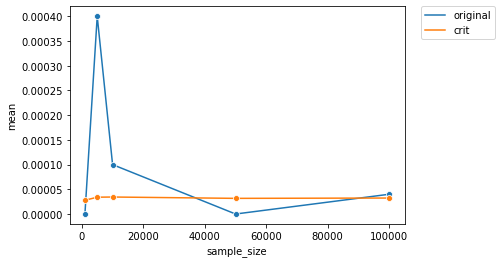

In [154]:
sns.lineplot(x='sample_size', y='mean', hue='experiment', data=df_importance, markers=True, marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)